<a href="https://colab.research.google.com/github/dareng5/PythonProject3/blob/master/Unit3Porject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Social Distancing and Enforcement**
Covid-19 Compliance with NYC Park Rules<br>From April 14, 2020 – July 29, 2020<br>Observations of park officers on daily patrols<br>In numerous parks in each of NYC  5 Boroughs<br><br>By Darren(Ka Hei) Ng, Peggy Taylor and Tahmina Akter

#Source  and Description of dataset

https://data.cityofnewyork.us/dataset/Social-Distancing-and-Enforcement-Parks-Patrol-Dat/yv25-wqf9

This data includes: | This data excludes:
--- | ---
Each data row is a single patrol on a portion of NYC parks property. | Data restricted to Covid-19 related incidents while on patrols.
Method of collection was mobile device or computer, and was cleaned daily. | There is no demographic data on the patrons encountered.
Park demographics and observations of the park officers on patrol are field<br />  columns in dataset.  | Does not account for every feature nor every park in each borough.
‘No Encounters’ are patrols where there is neither trespassing on closed park<br />  property, nor lack of social distancing in enclosed areas.  | Dataset values change frequently to reflect changes in re-openings <br /> and new policy decisions affecting compliance.
Encounters have been renamed  as “incidents” in the visualizations. | 

#Data Examination - Data Dictionary

Of the 24 fields in the dataset, those pertinent to our visualization are:

*   encounter_datetime - date and time of the encounters/patrols
*   encounter_type - determines the type of entry that was submitted: did officer encounter any patrons that were trespassing or needed to be educated on social distancing?
*   simplified_encounter_type – edited version of encounter type response to allow for easier comparison and analysis with other datasets in collection.
*   closed_amenity - closed feature within the park where a trespassing patrons were found. (examples: baseball field, golf coarse, etc.)
*   sd_amenity - feature within the park where patrons were educated on social distancing.
*   park_borough - borough that the park is located in.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime as dt
import math
import statsmodels.api as sm

#import data from NYC Open Data
df = pd.read_csv('https://raw.githubusercontent.com/dareng5/DataSets/master/Social_Distancing_and_Enforcement__Parks_Patrol_Data.csv', parse_dates=['encounter_datetime'], infer_datetime_format=True)
print(df)
print(df.dtypes)

#breakdown the datetime
df['year'] = df.encounter_datetime.dt.year
df['month'] = df.encounter_datetime.dt.month_name()
df['hour'] = df.encounter_datetime.dt.hour
df['weekofyear'] = df.encounter_datetime.dt.weekofyear.astype(str).replace('\.0', '', regex=True)
df['dayofyear'] = df.encounter_datetime.dt.dayofyear

#drop rows without date or encounter type
df = df.dropna(subset=['encounter_datetime','simplified_encounter_type'])

#drop rows with probably wrong year
df = df[df['year']==2020]

#assign shift from hour
df['shift'] = pd.cut(df['hour'], [-1,7,15,23],labels=['0000-0800','0800-1600','1600-2400'])

#add patrol count
df['count'] = 1

#combine and clean up amenity
df['amenity'] = df['closed_amenity'].fillna('') + df['sd_amenity'].fillna('')
df = df.replace({'amenity':{'Beach - Water':'Beach', 'Dog Run':'Dog run', 'Tennis court':'Tennis courts'}})

#rename Patrons in Closed Area
df = df.replace({'simplified_encounter_type':{'Patrons in Closed Area':'Trespassing'}})

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,4,7,9,10,11,12,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


       encounter_datetime park_area_id  ... other_summonscount   park_borough
0     2020-07-08 10:45:00         B025  ...                NaN       Brooklyn
1     2020-07-08 11:08:00         R030  ...                NaN  Staten Island
2     2020-07-08 10:44:00         R150  ...                NaN  Staten Island
3     2020-07-08 10:25:00         B114  ...                NaN       Brooklyn
4     2020-07-08 10:08:00         R109  ...                NaN  Staten Island
...                   ...          ...  ...                ...            ...
37149 2020-07-29 17:48:00     M010-151  ...                NaN      Manhattan
37150 2020-07-29 17:44:00     M010-169  ...                NaN      Manhattan
37151 2020-07-29 13:55:00         Q029  ...                NaN         Queens
37152 2020-07-29 12:23:00         Q004  ...                NaN         Queens
37153 2020-07-29 01:30:00         B431  ...                NaN       Brooklyn

[37154 rows x 24 columns]
encounter_datetime           datetime

#Formulate question(s) to answer

What were the Parks Patrol Results by Borough?  - Vis 1

How do those results compare by month? – Vis 1

How did the incident rate vary by park features ?  - Vis 2

How did the incidents vary by morning , noon and night? - Vis 3

Can we predict on what date the incident would trend to zero? - Vis 4

---



What were the Parks Patrol Results by Borough? - Vis 1

How do those results compare by month? – Vis 1

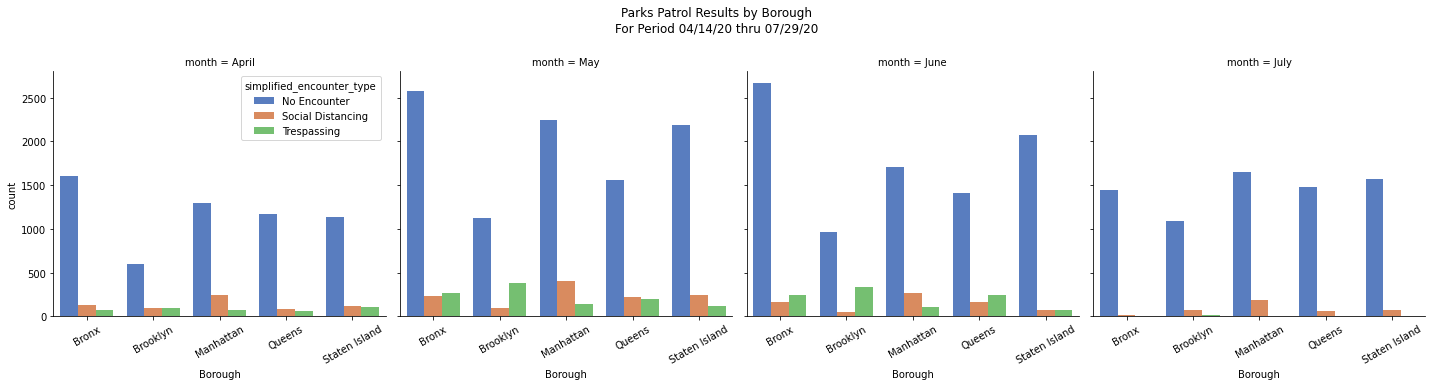

In [9]:
#showing results of patrols by borough over time
dfborough = df.groupby(['month','park_borough','simplified_encounter_type'])['count'].sum().reset_index()

g1 = sns.catplot(x='park_borough', y='count', hue='simplified_encounter_type',
                 col='month', col_order=['April','May','June','July'],
                 data=dfborough, kind='bar', palette=sns.color_palette('muted'), legend_out=False)
plt.subplots_adjust(top=.8)
g1.fig.suptitle('Parks Patrol Results by Borough\nFor Period 04/14/20 thru 07/29/20')
g1.set_xticklabels(rotation=30)
g1.set_axis_labels('Borough')
plt.show(g1)

How did the incident rate vary by park features ? - Vis 2

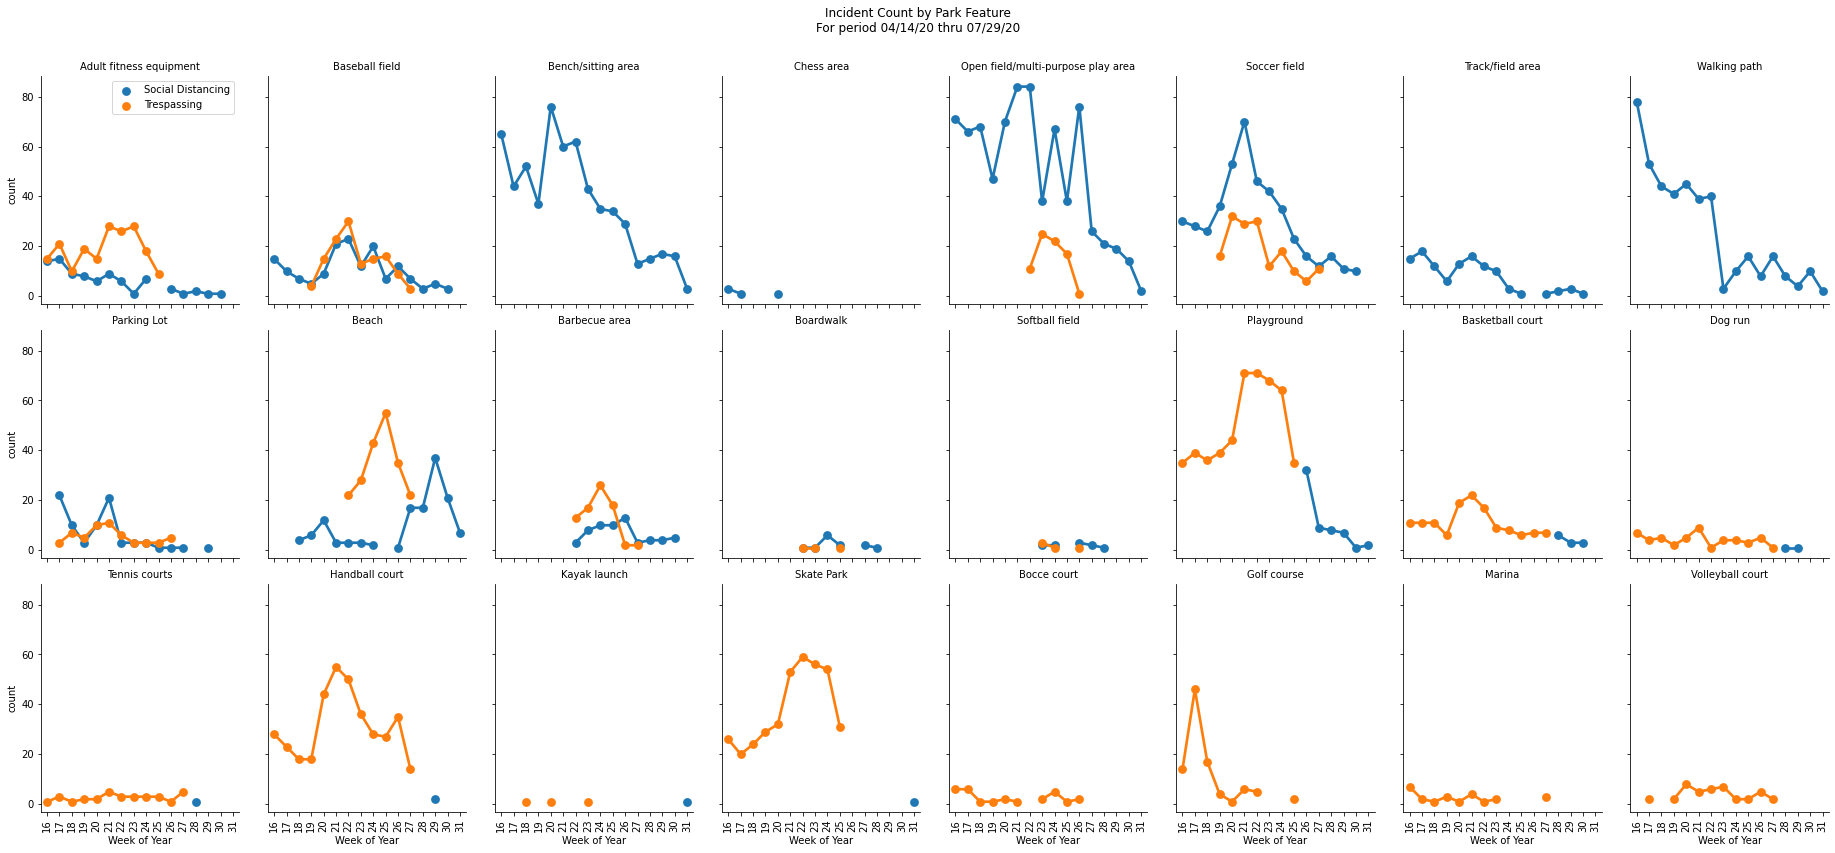

In [10]:
#showing encounter by Amenity over time
dfanemity = df[(df['simplified_encounter_type']!='No Encounter')]
dfanemity = dfanemity.groupby(['simplified_encounter_type','weekofyear','amenity'])['count'].sum().reset_index()

g2 = sns.catplot(x='weekofyear', y='count', hue='simplified_encounter_type',
                 col='amenity', col_wrap=8,
                 data=dfanemity, kind='point',
                 height=4, aspect=.8, legend_out=False)
plt.subplots_adjust(top=.9)
g2.fig.suptitle('Incident Count by Park Feature\nFor period 04/14/20 thru 07/29/20')
g2.set_titles("{col_name}")
g2.set_xticklabels(rotation=90)
g2.set_axis_labels('Week of Year')
g2._legend.set_title('')
plt.show(g2)

How did the incidents vary by morning , noon and night? - Vis 3

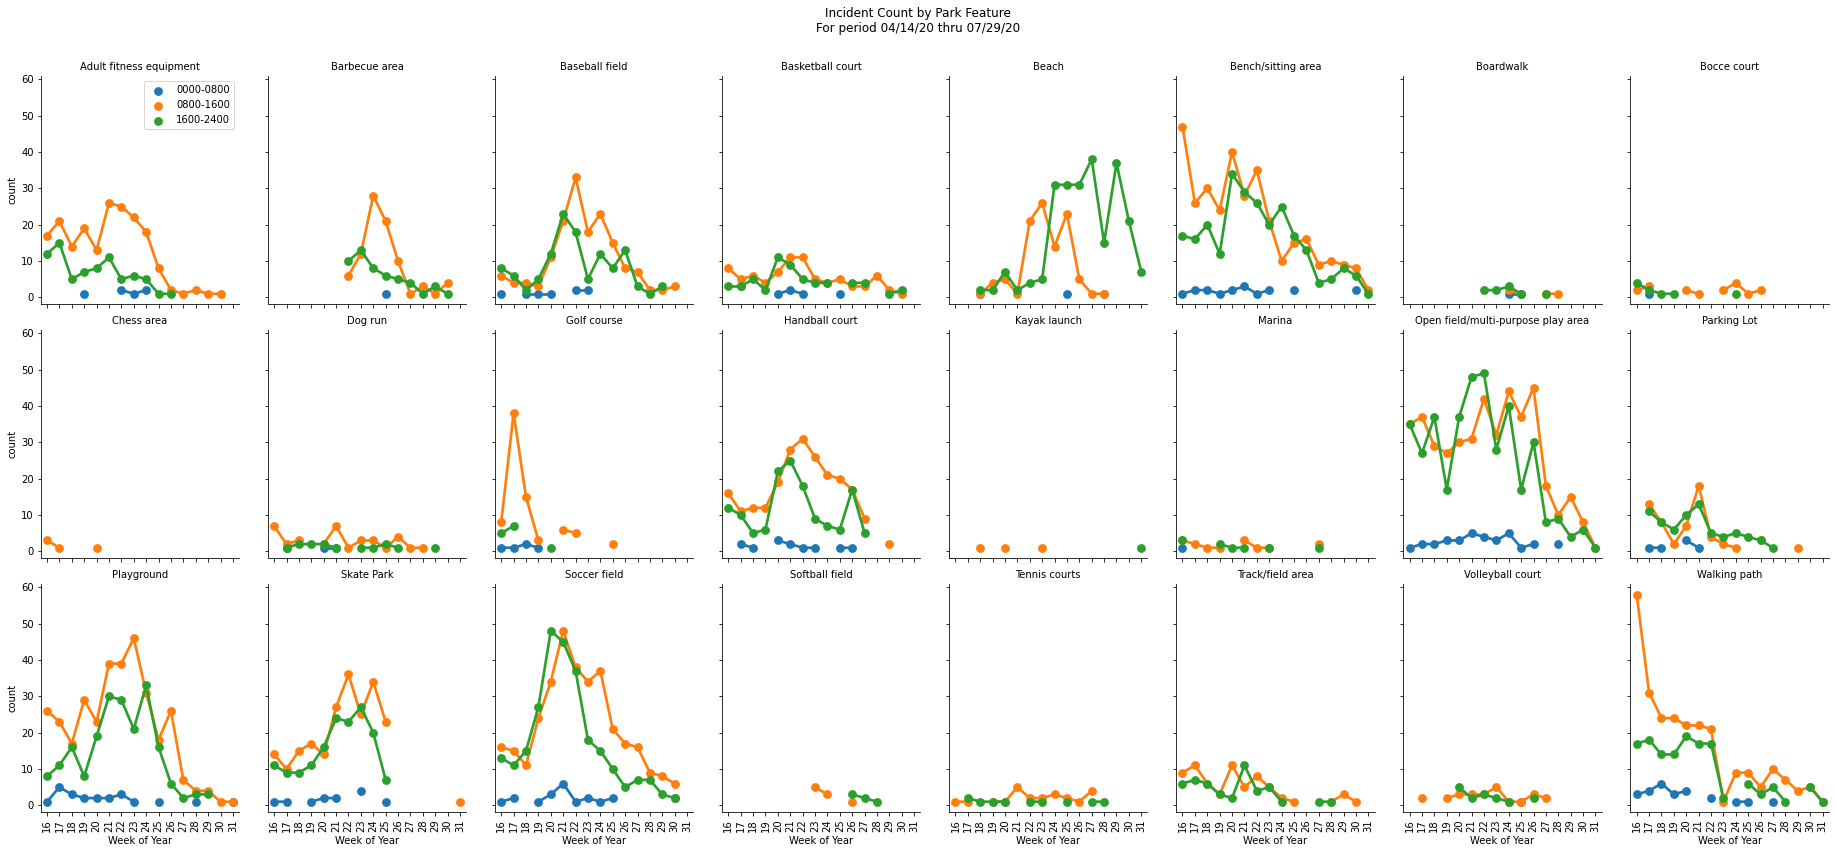

In [11]:
#showing encounter by Amenity over time
dfshift = df[(df['simplified_encounter_type']!='No Encounter')]
dfshift = dfshift.groupby(['shift','weekofyear','amenity'])['count'].sum().reset_index()

g3 = sns.catplot(x='weekofyear', y='count', hue='shift',
                 col='amenity', col_wrap=8,
                 data=dfshift, kind='point',
                 height=4, aspect=.8, legend_out=False)
plt.subplots_adjust(top=.9)
g3.fig.suptitle('Incident Count by Park Feature\nFor period 04/14/20 thru 07/29/20')
g3.set_titles("{col_name}")
g3.set_xticklabels(rotation=90)
g3.set_axis_labels('Week of Year')
g3._legend.set_title('')
plt.show(g3)

Can we predict on what date the incident would trend to zero? - Vis 4

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     37.73
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           1.48e-08
Time:                        22:45:15   Log-Likelihood:                -450.18
No. Observations:                 107   AIC:                             904.4
Df Residuals:                     105   BIC:                             909.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.8403      8.268      9.414      0.0

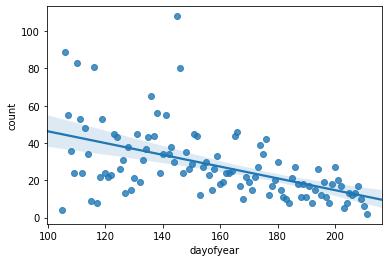


The estimated date of no scoial distancing encounter from patrols is 2020-09-03.


In [12]:
#trending on social distancing encounter
dftrend = df[(df['simplified_encounter_type']=='Social Distancing')]
dftrend = dftrend.groupby(['dayofyear'])['count'].sum().reset_index()

#fit a linear model using OLS (ordinary least squares) method
model = sm.OLS(dftrend['count'], sm.add_constant(dftrend['dayofyear']))
results = model.fit()
print(results.summary())

#plot graph
g4 = sns.regplot(x='dayofyear', y='count', data=dftrend, truncate=False)
plt.show(g4)

#estimate date where social distancing encounter = 0
d1 = int(math.ceil(-results.params['const']/results.params['dayofyear']))
d2 = pd.to_datetime(2020 * 1000 + d1, format='%Y%j').date()
print('\nThe estimated date of no scoial distancing encounter from patrols is ' + str(d2) + '.')

#    y     = -0.3154x +  77.8403
#-77.8403  = -0.3154x
#    x     = -77.8403/-0.31541